# Rolling Gerber Calculation Fix

## Packages

In [1]:
import time
import itertools
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

## Collect data

In [2]:
try:
    
    df = pd.read_csv("maang_data.csv", index_col = 0)
    print("read from file")
    
except:
    
    tickers = ["AAPL", "AMZN", "META", "NFLX", "GOOG"]
    df = yf.download(tickers)["Adj Close"]
    df.to_csv("maang_data.csv")
    print("collected from yahoo")

read from file


In [3]:
df_rtns = df.dropna().pct_change().dropna()

## Pre Method Calculations

parameters that we are setting

In [4]:
threshold = 1/2

In [5]:
hk = (df_rtns.std().reset_index().rename(
    columns = {0: "std_dev", "index": "ticker"}).
    assign(
        ck = threshold,
        h_k = lambda x: x.ck * x.std_dev)
    [["ticker", "h_k"]])

In [6]:
threshold_df = (df_rtns.reset_index().melt(
    id_vars = "Date").
    rename(columns = {"variable": "ticker", "value": "rtns"}).
    merge(hk, how = "outer", on = "ticker"))

## Method 1

In [11]:
combinations = list(itertools.combinations(df_rtns.columns.to_list(),2))
m_ij = pd.DataFrame(columns = ["Date", "m_ij", "ticker1", "ticker2"]).set_index("Date")
gerber_stat = pd.DataFrame(columns = ["ticker1", "ticker2", "gerber_stat"])

In [19]:
for combo in combinations:
    
    returns_tmp = (threshold_df[[
        "Date", "ticker", "rtns"]].
        query("ticker == [@combo[0], @combo[1]]").
        pivot(index = "Date", columns = "ticker", values = "rtns").
        rename(columns = 
              {combo[0]: "{}_rtns".format(combo[0]),
               combo[1]: "{}_rtns".format(combo[1])}))
    
    hk_rtmp = (threshold_df[
        ["Date", "ticker", "h_k"]].
        query("ticker == [@combo[0], @combo[1]]").
        pivot(index = "Date", columns = "ticker", values = "h_k").
        rename(columns = 
              {combo[0]: "{}_hk".format(combo[0]),
               combo[1]: "{}_hk".format(combo[1])}))
    
    combined_tmp = (returns_tmp.merge(hk_rtmp, how = "inner", on = "Date"))
    
    combined_tmp.loc[
        (combined_tmp["{}_rtns".format(combo[0])] >= combined_tmp["{}_hk".format(combo[0])]) &
        (combined_tmp["{}_rtns".format(combo[1])] >= combined_tmp["{}_hk".format(combo[1])]),
    "m_ij"] = 1
    
    combined_tmp.loc[
        (combined_tmp["{}_rtns".format(combo[0])] <= - combined_tmp["{}_hk".format(combo[0])]) &
        (combined_tmp["{}_rtns".format(combo[1])] <= - combined_tmp["{}_hk".format(combo[1])]),
    "m_ij"] = 1
    
    combined_tmp.loc[
        (combined_tmp["{}_rtns".format(combo[0])] >= combined_tmp["{}_hk".format(combo[0])]) &
        (combined_tmp["{}_rtns".format(combo[1])] <= - combined_tmp["{}_hk".format(combo[1])]),
    "m_ij"] = -1
    
    combined_tmp.loc[
        (combined_tmp["{}_rtns".format(combo[0])] <= - combined_tmp["{}_hk".format(combo[0])]) &
        (combined_tmp["{}_rtns".format(combo[1])] >= combined_tmp["{}_hk".format(combo[1])]),
    "m_ij"] = -1
    
    combined_tmp = (combined_tmp.fillna(0)[["m_ij"]].assign(
                ticker1 = combo[0], 
                ticker2 = combo[1]))
    
    break

<AxesSubplot:xlabel='Date'>

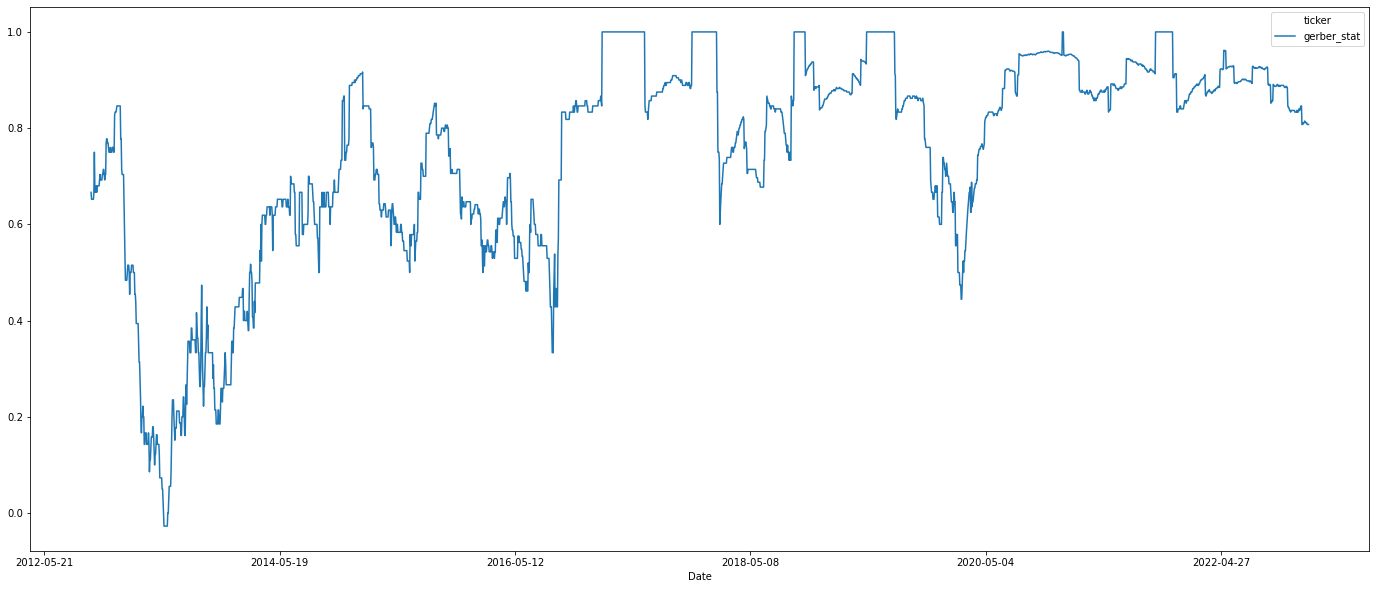

In [31]:
(combined_tmp.assign(
    numerator = lambda x: x.m_ij.rolling(window = 100).sum(),
    denominator = lambda x: np.abs(x.m_ij).rolling(window = 100).sum(),
    gerber_stat = lambda x: x.numerator / x.denominator)
    [["gerber_stat"]].
    plot(figsize = (24,10)))

## Try using SPY and TLT

In [36]:
try:
    
    cross_asset_df = pd.read_csv("cross_asset.csv", index_col = 0)
    print("read from file")

except:
    
    cross_asset_df = yf.download(tickers  = ["SPY", "TLT"])["Adj Close"].dropna()
    cross_asset_df.to_csv("cross_asset.csv")
    print("collected from yahoo")

[*********************100%***********************]  2 of 2 completed
collected from yahoo


In [51]:
rtns = cross_asset_df.pct_change().dropna()
combo = (cross_asset_df_tmp.columns[0], cross_asset_df_tmp.columns[1])
threshold_constant = 1/2

In [56]:
(rtns.rolling(
    window = 100).
    std().
    dropna().
    reset_index().
    melt(id_vars = "Date").
    assign(
        c_k = threshold_constant,
        h_k = lambda x: x.c_k * x.value))

,Date,variable,value,c_k,h_k
0,2002-12-19,SPY,0.018840,0.5,0.009420
1,2002-12-20,SPY,0.018892,0.5,0.009446
2,2002-12-23,SPY,0.018705,0.5,0.009353
3,2002-12-24,SPY,0.018580,0.5,0.009290
4,2002-12-26,SPY,0.018234,0.5,0.009117
...,...,...,...,...,...
10117,2023-01-23,TLT,0.014019,0.5,0.007009
10118,2023-01-24,TLT,0.014094,0.5,0.007047
10119,2023-01-25,TLT,0.014065,0.5,0.007033
10120,2023-01-26,TLT,0.013953,0.5,0.006977
